In [2]:
%matplotlib inline


import torch
import numpy as np
import matplotlib.pyplot as plt
import gpytorch
from gpytorch import kernels
import tqdm

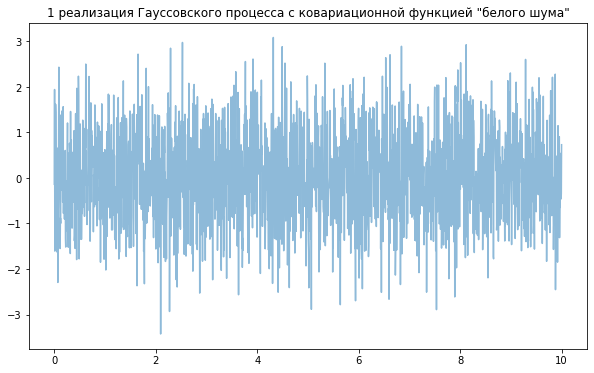

In [2]:
plt.figure(figsize=(10,6))
plt.title('1 реализация Гауссовского процесса с ковариационной функцией "белого шума"')
for _ in range(1):
    N = 2000
    X = np.linspace(0,10,N)
    f = np.random.randn(N)
    plt.plot(X, f, alpha=0.5)


In [4]:
X = torch.tensor(np.linspace(0,10,200))
mu = np.zeros(200)

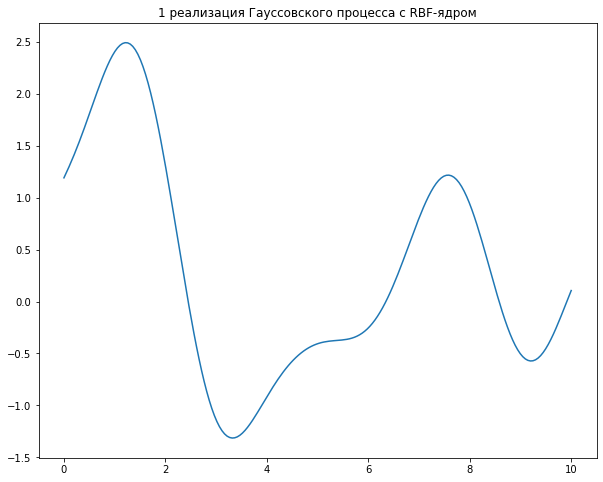

In [36]:
rbf = kernels.RBFKernel()
rbf.lengthscale = 1 
with torch.no_grad():
    
    cov_matrix = rbf(X).evaluate().numpy()
    
dist = np.random.multivariate_normal(mu, cov_matrix, 10)

plt.figure(figsize=(10,8))
plt.title('1 реализация Гауссовского процесса с RBF-ядром')

for i in range(1):
    plt.plot(X.numpy(), dist[i])
    

In [48]:
def plot_kernel(kernel, xlim=None, ax=None, t=None):
    if xlim is None:
        xlim = [0, 8]
    x = torch.linspace(xlim[0], xlim[1], 100)
    with torch.no_grad():
        K = kernel(x, torch.zeros((1))).evaluate().reshape(-1, 1)
    
    if ax is None:
        fig = plt.figure(figsize=(8,6))
        ax = fig.add_subplot(111)
    ax.plot(x.numpy(), K.cpu().numpy())
    ax.set_title(t)
    ax.set_xlabel('Расстояние между точками')
    ax.set_ylabel('Значение ковариационной функции')


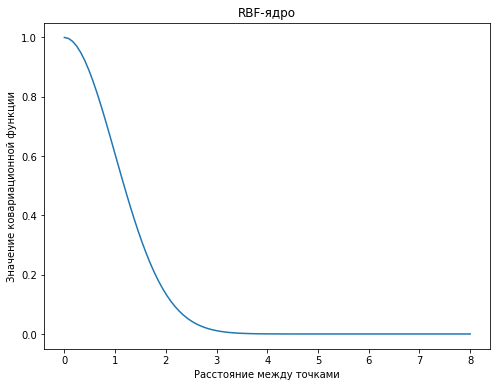

In [49]:
plot_kernel(rbf, t = 'RBF-ядро')

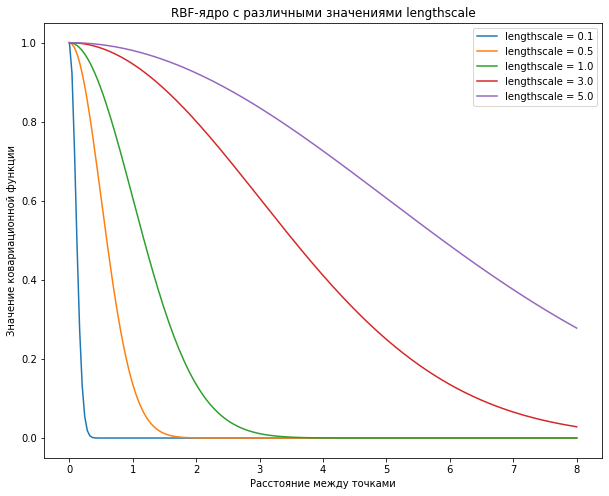

In [83]:
k = kernels.RBFKernel() 
x = torch.linspace(0,8,200)
length = np.asarray([0.1,0.5,1,3,5])
plt.figure(figsize=(10,8))
plt.title('RBF-ядро с различными значениями lengthscale')
plt.xlabel('Расстояние между точками')
plt.ylabel('Значение ковариационной функции')
for l in length:
    k.lengthscale = l
    with torch.no_grad():
        vals = k(x, torch.zeros((1))).evaluate().reshape(-1, 1)
    plt.plot(x.numpy(), vals.numpy(), label='lengthscale = {}'.format(l))
    plt.legend()

    


In [3]:

def k(xs, ys, sigma=1, l=1):
    """Sqared Exponential kernel as above but designed to return the whole
    covariance matrix - i.e. the pairwise covariance of the vectors xs & ys.
    Also with two parameters which are discussed at the end."""

    # Pairwise difference matrix.
    dx = np.expand_dims(xs, 1) - np.expand_dims(ys, 0)
    return (sigma ** 2) * np.exp(-((dx / l) ** 2) / 2)

def m(x):
    """The mean function. As discussed, we can let the mean always be zero."""
    return np.zeros_like(x)




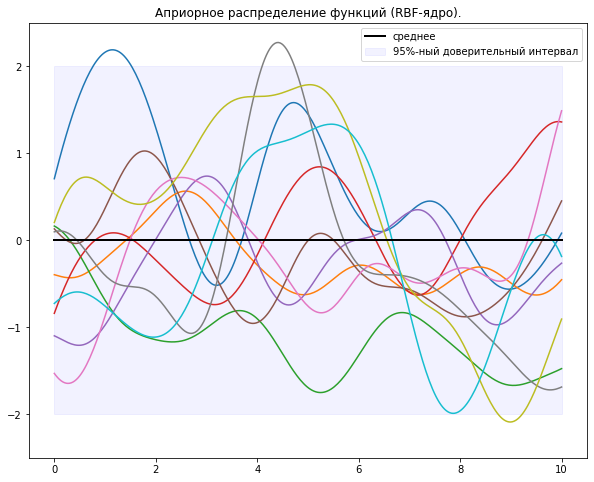

In [23]:
plt.figure(figsize=(10,8))
plt.ylim([-2.5,2.5])
plt.title('Априорное распределение функций (RBF-ядро).')
xs = np.linspace(0, 10, 300)
np.random.seed(1001)
for i in range(10):
    ys = np.random.multivariate_normal(m(xs), k(xs, xs, sigma=1, l=1))
    plt.plot(xs, ys)
    
plt.fill_between(xs, 2*1, -2*1, color='b', alpha=0.05, label='95%-ный доверительный интервал')
plt.plot(xs, [0]*300, c='black', linewidth=2, label='среднее')
plt.legend()


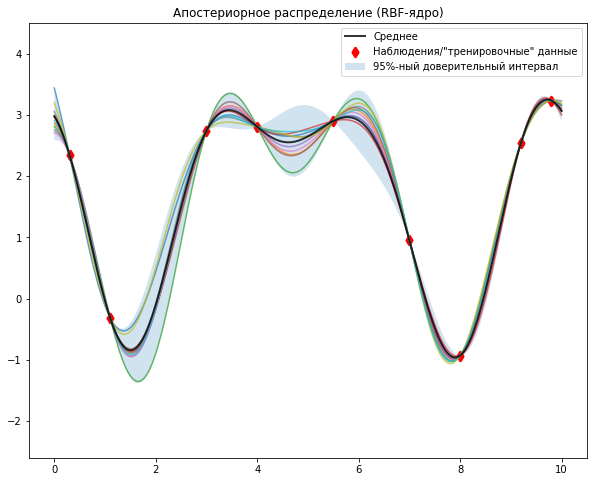

In [91]:
coefs = [3, -1.5, -2.4, -0.1]

def f(x):
    total = 0
    for exp, coef in enumerate(coefs):
        total += coef * (np.sin(x) ** exp)
    return total

x_obs = np.array([0.3, 1.1, 3, 4, 5.5, 7, 8, 9.2, 9.8])
y_obs = f(x_obs)

x_s = np.linspace(0, 10, 300)
np.random.seed(1001)

K = k(x_obs, x_obs)
K_s = k(x_obs, x_s)
K_ss = k(x_s, x_s)

K_sTKinv = np.matmul(K_s.T, np.linalg.pinv(K))

mu_s = m(x_s) + np.matmul(K_sTKinv, y_obs - m(x_obs))
Sigma_s = K_ss - np.matmul(K_sTKinv, K_s)

plt.figure(figsize=(10,8))
plt.title('Апостериорное распределение (RBF-ядро)')
plt.ylim([-2.6,4.5])
st_deviation = np.sqrt(Sigma_s.diagonal())  

for i in range(10):
    y_s = np.random.multivariate_normal(mu_s, Sigma_s)
    plt.plot(x_s, y_s, alpha=0.7)
    
plt.scatter(x_obs, y_obs, marker='d', color='red', linewidth=3, label='Наблюдения/"тренировочные" данные')
plt.fill_between(x_s, mu_s+ (2*st_deviation), mu_s - (2*st_deviation), alpha=0.2, label='95%-ный доверительный интервал')
plt.plot(x_s, mu_s, color='black', linestyle='-', linewidth=2, alpha=0.8, label='Среднее')
plt.legend()

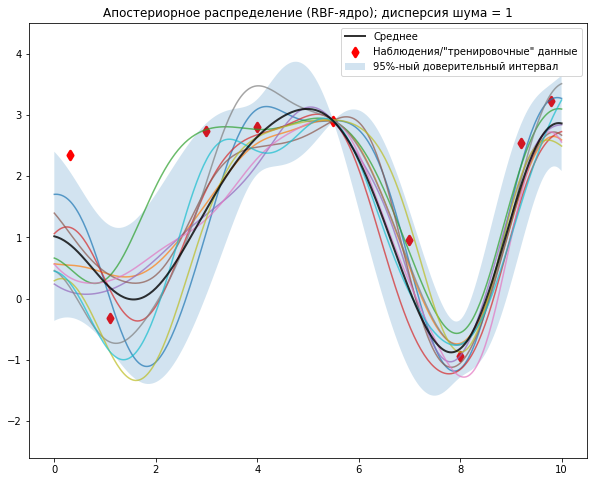

In [118]:
coefs = [3, -1.5, -2.4, -0.1]

def f(x):
    total = 0
    for exp, coef in enumerate(coefs):
        total += coef * (np.sin(x) ** exp)
    return total

x_obs = np.array([0.3, 1.1, 3, 4, 5.5, 7, 8, 9.2, 9.8])
noise = np.random.normal(0,1,len(x_obs))**2
y_obs = f(x_obs)

x_s = np.linspace(0, 10, 300)
np.random.seed(1001)

K = k(x_obs, x_obs)
K_s = k(x_obs, x_s)
K_ss = k(x_s, x_s)

K_sTKinv = np.matmul(K_s.T, np.linalg.pinv(K  + np.diag(noise)))

mu_s = m(x_s) + np.matmul(K_sTKinv, y_obs - m(x_obs))
Sigma_s = K_ss - np.matmul(K_sTKinv, K_s)

plt.figure(figsize=(10,8))
plt.title('Апостериорное распределение (RBF-ядро); дисперсия шума = 1')
plt.ylim([-2.6,4.5])
st_deviation = np.sqrt(Sigma_s.diagonal())  

for i in range(10):
    y_s = np.random.multivariate_normal(mu_s, Sigma_s)
    plt.plot(x_s, y_s, alpha=0.7)
    
plt.scatter(x_obs, y_obs, marker='d', color='red', linewidth=3, label='Наблюдения/"тренировочные" данные')
plt.fill_between(x_s, mu_s+ (2*st_deviation), mu_s - (2*st_deviation), alpha=0.2, label='95%-ный доверительный интервал')
plt.plot(x_s, mu_s, color='black', linestyle='-', linewidth=2, alpha=0.8, label='Среднее')
plt.legend()

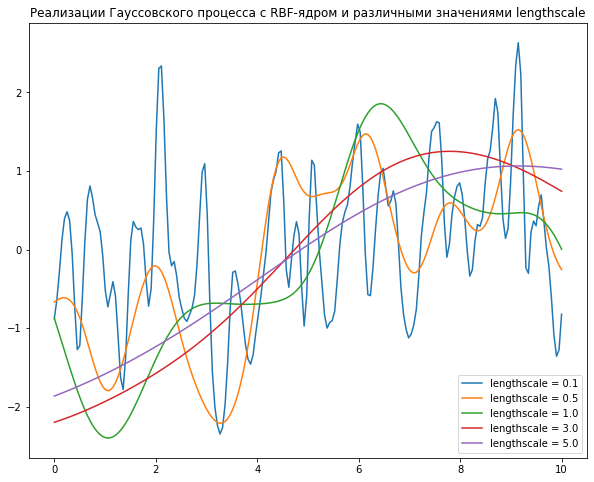

In [93]:
X = torch.tensor(np.linspace(0,10,200))
mu = np.zeros(200)
length = np.asarray([0.1,0.5,1,3,5])

rbf = kernels.RBFKernel()
plt.figure(figsize=(10,8))
plt.title('Реализации Гауссовского процесса с RBF-ядром и различными значениями lengthscale')
for l in length:
    torch.manual_seed(88)
    np.random.seed(88)
    with torch.no_grad():
        rbf.lengthscale = l
        cov_matrix = rbf(X).evaluate().numpy()
        dist = np.random.multivariate_normal(mu, cov_matrix, 10)
        plt.plot(X, dist[0], label='lengthscale = {}'.format(l))
        plt.legend()




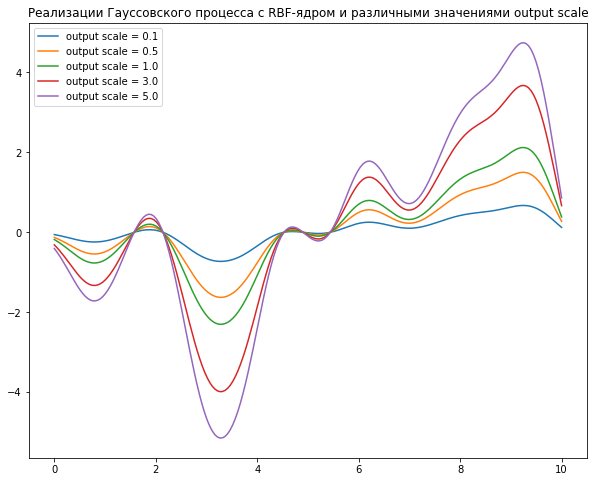

In [244]:
X = torch.tensor(np.linspace(0,10,200))
mu = np.zeros(200)
length = np.asarray([0.1,0.5,1,3,5])

rbf = kernels.ScaleKernel(kernels.RBFKernel())
plt.figure(figsize=(10,8))
plt.title('Реализации Гауссовского процесса с RBF-ядром и различными значениями output scale')
for l in length:
    torch.manual_seed(88)
    np.random.seed(88)
    with torch.no_grad():
        rbf.outputscale = l
        cov_matrix = rbf(X).evaluate().numpy()
        dist = np.random.multivariate_normal(mu, cov_matrix, 10)
        plt.plot(X, dist[0], label='output scale = {}'.format(l))
        plt.legend()




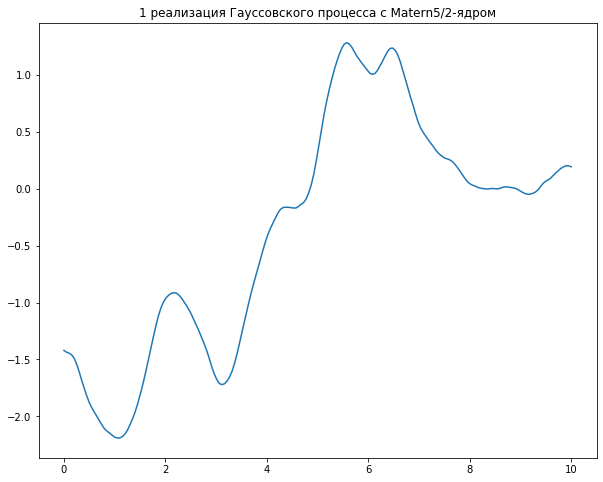

In [52]:
matern52 = kernels.MaternKernel(nu=2.5)
matern52.lengthscale = 1
with torch.no_grad():
    
    cov_matrix = matern52(X).evaluate().numpy()
    
dist = np.random.multivariate_normal(mu, cov_matrix, 10)

plt.figure(figsize=(10,8))
plt.title('1 реализация Гауссовского процесса с Matern5/2-ядром')

for i in range(1):
    plt.plot(X.numpy(), dist[i])

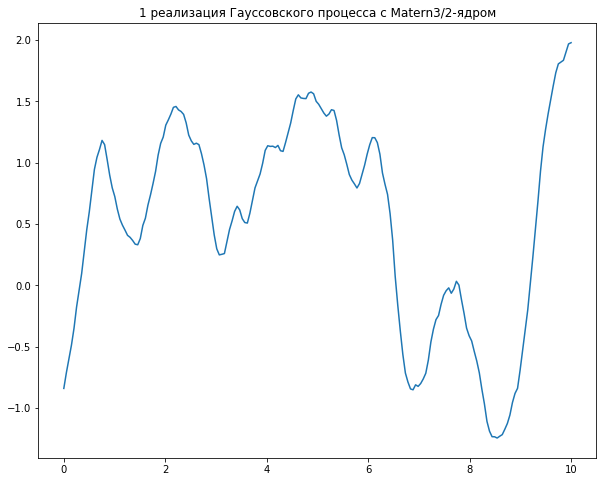

In [50]:
matern32 = kernels.MaternKernel(nu=1.5)
matern32.lengthscale=1
with torch.no_grad():
    
    cov_matrix = matern32(X).evaluate().numpy()
    
dist = np.random.multivariate_normal(mu, cov_matrix, 10)

plt.figure(figsize=(10,8))
plt.title('1 реализация Гауссовского процесса с Matern3/2-ядром')

for i in range(1):
    plt.plot(X.numpy(), dist[i])

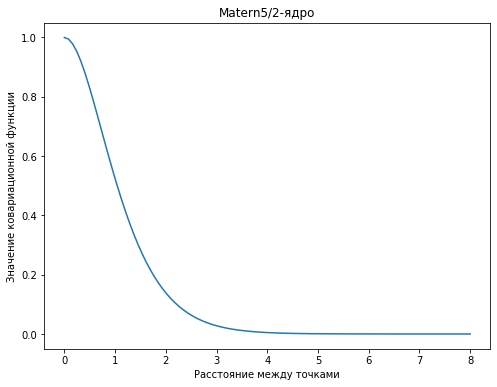

In [53]:
plot_kernel(matern52, t = 'Matern5/2-ядро')

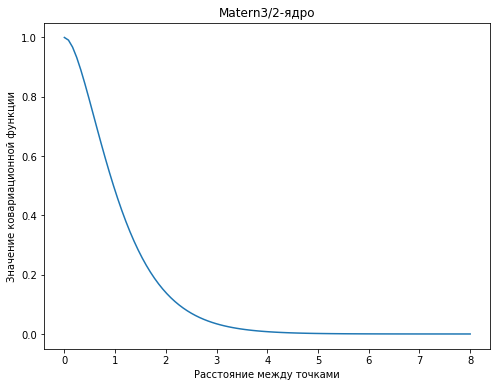

In [51]:
plot_kernel(matern32, t = 'Matern3/2-ядро')

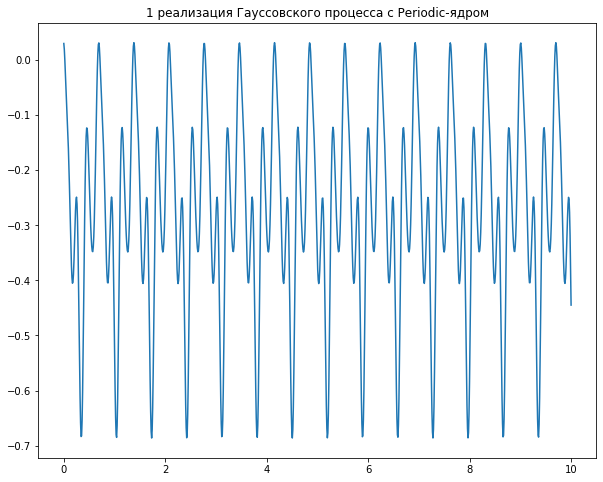

In [105]:
periodic = kernels.PeriodicKernel()
periodic.lengthscale = 1
with torch.no_grad():
    
    cov_matrix = periodic(X).evaluate().numpy()
    
dist = np.random.multivariate_normal(mu, cov_matrix, 10)

plt.figure(figsize=(10,8))
plt.title('1 реализация Гауссовского процесса с Periodic-ядром')

for i in range(1):
    plt.plot(X.numpy(), dist[i])

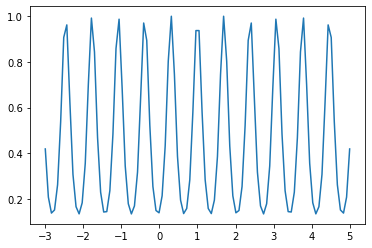

In [126]:
plot_kernel(periodic)

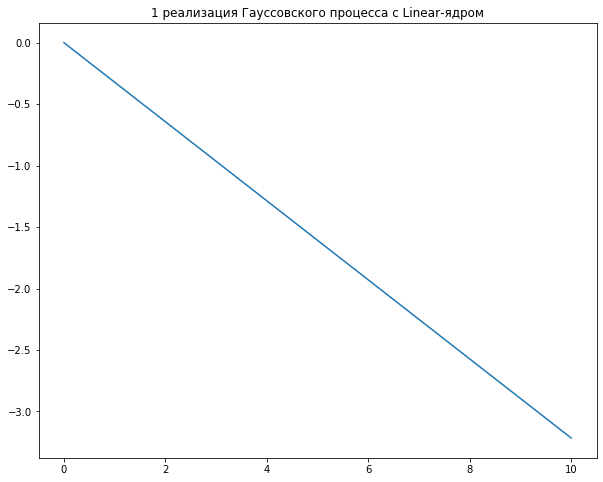

In [59]:
linear = kernels.LinearKernel()
with torch.no_grad():
    
    cov_matrix = periodic(X).evaluate().numpy()
    
dist = np.random.multivariate_normal(mu, cov_matrix, 10)

plt.figure(figsize=(10,8))
plt.title('1 реализация Гауссовского процесса с Linear-ядром')

for i in range(1):
    plt.plot(X.numpy(), dist[i])

In [132]:
def plot_kernel(kernel, xlim=None, ax=None):
    if xlim is None:
        xlim = [-3, 5]
    x = torch.linspace(xlim[0], xlim[1], 100)
    with torch.no_grad():
        K = kernel(x, torch.ones((1))).evaluate().reshape(-1, 1)
    
    if ax is None:
        fig = plt.figure(figsize = (10,6))
        ax = fig.add_subplot(111)
    ax.plot(x.numpy(), K.cpu().numpy())

Text(0.5, 1.0, 'Linear-ядро + RBF-ядро')

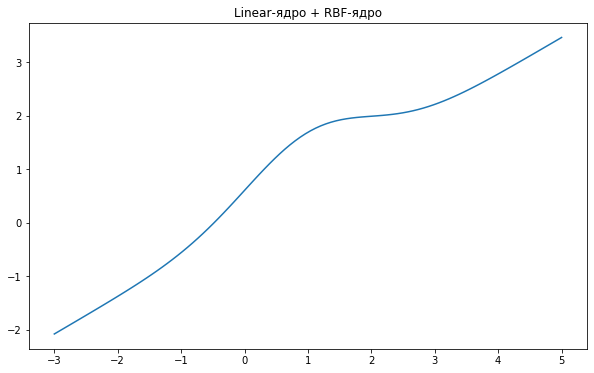

In [159]:
k1 = kernels.RBFKernel()
k1.lengthscale = 1
k2 = kernels.LinearKernel()

k_s = k1 + k2
plot_kernel(k_s)
plt.title('Linear-ядро + RBF-ядро')

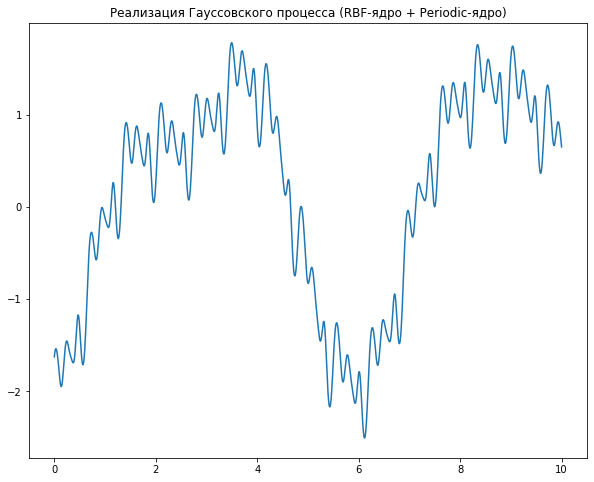

In [157]:
with torch.no_grad():
    
    cov_matrix = k_s(X).evaluate().numpy()
    
dist = np.random.multivariate_normal(mu, cov_matrix, 10)

plt.figure(figsize=(10,8))
plt.title('Реализация Гауссовского процесса (RBF-ядро + Periodic-ядро)')

for i in range(1):
    plt.plot(X.numpy(), dist[i])

Text(0.5, 1.0, 'Linear-ядро * RBF-ядро')

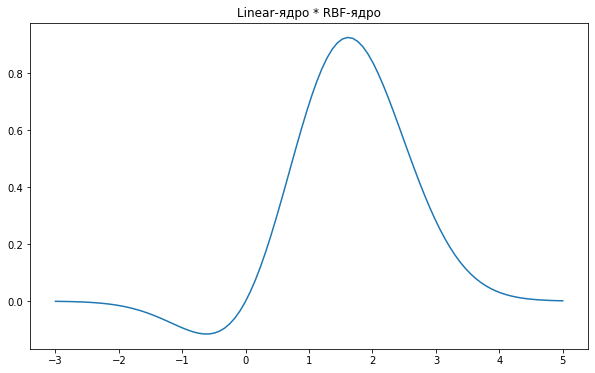

In [161]:
k1 = kernels.RBFKernel()
k1.lengthscale = 1
k2 = kernels.LinearKernel()

rbf_lin = k1 * k2
plot_kernel(rbf_lin)
plt.title('Linear-ядро * RBF-ядро')

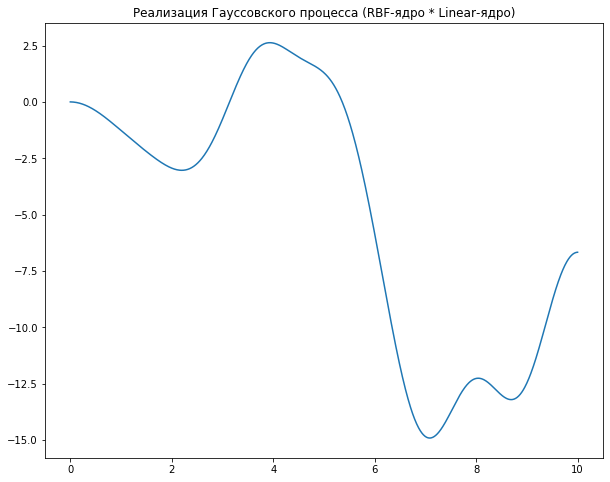

In [163]:
with torch.no_grad():
    
    cov_matrix = rbf_lin(X).evaluate().numpy()
    
dist = np.random.multivariate_normal(mu, cov_matrix, 10)

plt.figure(figsize=(10,8))
plt.title('Реализация Гауссовского процесса (RBF-ядро * Linear-ядро)')

for i in range(1):
    plt.plot(X.numpy(), dist[i])

Text(0.5, 1.0, 'Periodic-ядро * RBF-ядро')

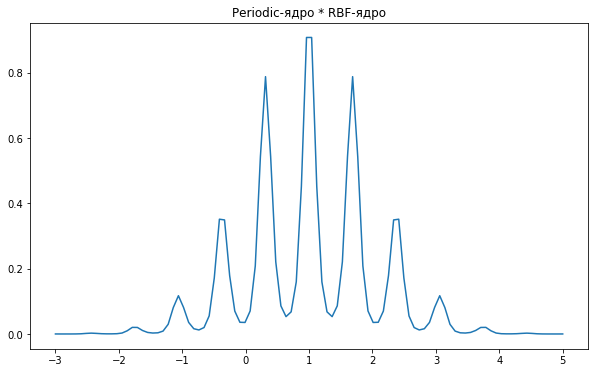

In [176]:
k1 = kernels.RBFKernel()
k1.lengthscale = 1
k2 = kernels.PeriodicKernel()

rbf_per = k1 * k2
plot_kernel(rbf_lin)
plt.title('Periodic-ядро * RBF-ядро')

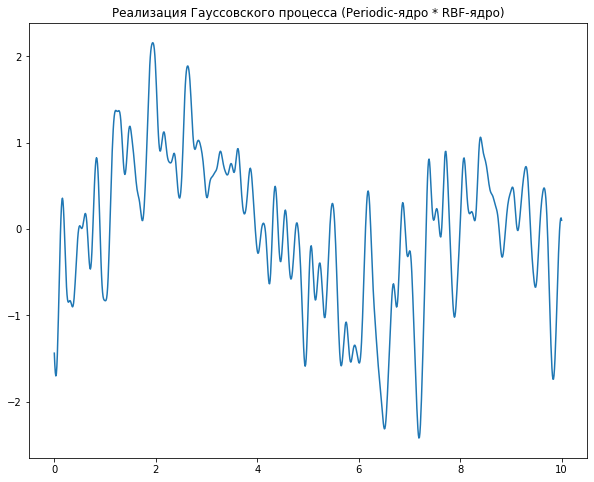

In [177]:
with torch.no_grad():
    
    cov_matrix = rbf_per(X).evaluate().numpy()
    
dist = np.random.multivariate_normal(mu, cov_matrix, 10)

plt.figure(figsize=(10,8))
plt.title('Реализация Гауссовского процесса (Periodic-ядро * RBF-ядро)')

for i in range(1):
    plt.plot(X.numpy(), dist[i])

Text(0.5, 1.0, 'RBF-ядро (lengthscale = 1) * RBF-ядро (lengthscale = 0.1)')

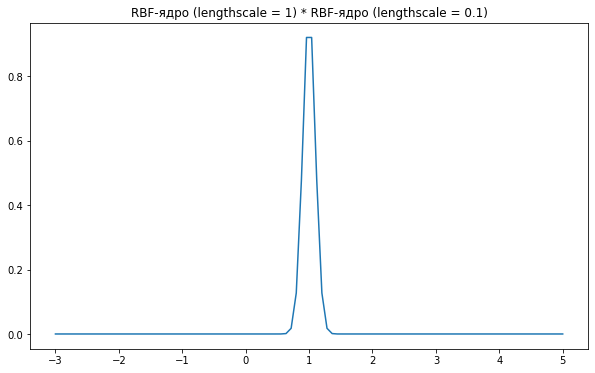

In [169]:
k1 = kernels.RBFKernel()
k1.lengthscale = 1
k2 = kernels.RBFKernel()
k2.lengthscale = 0.1

rbf_rbf = k1 * k2
plot_kernel(rbf_rbf)
plt.title('RBF-ядро (lengthscale = 1) * RBF-ядро (lengthscale = 0.1)')

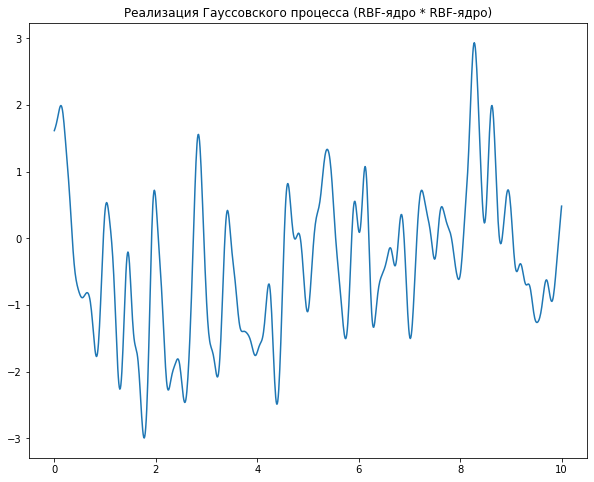

In [171]:
with torch.no_grad():
    
    cov_matrix = rbf_rbf(X).evaluate().numpy()
    
dist = np.random.multivariate_normal(mu, cov_matrix, 10)

plt.figure(figsize=(10,8))
plt.title('Реализация Гауссовского процесса (RBF-ядро * RBF-ядро)')

for i in range(1):
    plt.plot(X.numpy(), dist[i])

Text(0.5, 1.0, 'Periodic-ядро * Linear-ядро')

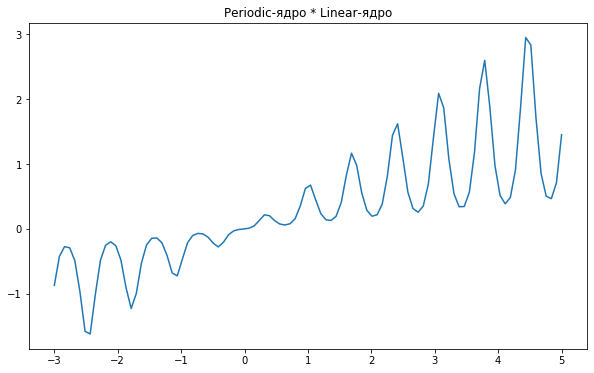

In [172]:
k1 = kernels.PeriodicKernel()
k1.lengthscale = 1
k2 = kernels.LinearKernel()


per_lin = k1 * k2
plot_kernel(per_lin)
plt.title('Periodic-ядро * Linear-ядро')

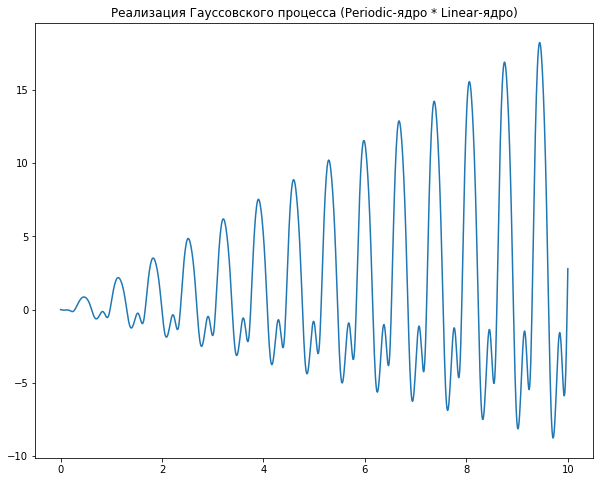

In [173]:
with torch.no_grad():
    
    cov_matrix = per_lin(X).evaluate().numpy()
    
dist = np.random.multivariate_normal(mu, cov_matrix, 10)

plt.figure(figsize=(10,8))
plt.title('Реализация Гауссовского процесса (Periodic-ядро * Linear-ядро)')

for i in range(1):
    plt.plot(X.numpy(), dist[i])